In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Условие задачи
Разработка модели предсказания потери почтовых отправлений.

Описание входных значений
● train.csv — файл, содержащий данные о посылках, включая статус
отправления;
● test.csv — файл, содержащий данные о посылках для предсказания ;
● sample_solution.csv — пример файла для отправки;

Расшифровка столбцов

oper_type + oper_attr   Тип и атрибут операции
index_oper              Индекс места операции
type                    Обозначение типа объекта почтовой связи
priority                Приоритет объекта
is_privatecategory      Y - является отделением закрытого типа, N - иначе
class                   Значение класса или категории объекта почтовой связи
is_in_yandex            Y - адрес отделения связи отображается в Яндекс-картах, N - иначе
is_return               Y - Отправление движется в направлении возврата отправителю, N - иначе
weight                  Вес в граммах
mailtype                Код вида отправления
mailctg                 Код категории почтового отправления
mailrank                Код разряда почтового отправления
directctg               Код классификации отправления
transport_pay           Общая сумма платы за пересылку в условной валюте
postmark                Код отметки
name_mfi                Наименование вложений (указано через запятую), указывается на бирке отправления
weight_mfi              Суммарная масса вложений
price_mfi               Суммарная стоимость вложений в условной валюте
dist_qty_oper_login_1   Количество уникальных имен операторов, задействованных в обработке данного типа отправлений (mailtype)                           на конкретном индексе, по которым возможно идентифицировать оператора
total_qty_oper_login_1  Количество отправлений с уникальным именем операторов, задействованных в обработке данного типа      
                        отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора
total_qty_oper_login_0  Количество отправлений данного типа (mailtype), которые были обработаны неизвестным оператором на этом 
                        индексе
total_qty_over_index_and_type    Общее количество отправлений данного типа (mailtype), прошедших обработку на этом индексе
total_qty_over_index    Общее количество отправлений, прошедших обработку на этом индексе
is_wrong_sndr_name      Есть ли явные признаки, что имя отправителя введено некорректно? 1 - да, 0 - иначе
is_wrong_rcpn_name      Есть ли явные признаки, что имя получателя введено некорректно? 1 - да, 0 - иначе
is_wrong_phone_number   Есть ли явные признаки, что номер телефона получателя введен некорректно? 1 - да, 0 - иначе
is_wrong_address        Есть ли явные признаки, что адрес получателя введен некорректно? 1 - да, 0 - иначе
label                   СТРОКА ДЛЯ ПРЕДСКАЗАНИЯ 1 - операция, на которой цифровой след оборвался, т.к. отправление потеряно
                        0 - отправление было вручено или возвращено отправителю

Метрика
В качестве метрики выступает комбинация двух значений:

Результирующее значение выглядит как:
Result = 0.1 * Recall + 0.9 * AUC_ROC
TP (True Positive) — количество верно угаданных значений того, что посылка
пропала.
FN (False Negative) — количество значений, где было предсказано, что
посылка пропадет, а она не пропала.
FP (False Positive) — количество значений, где было предсказано, что посылка
не пропадет, а она пропала.
TN (False Negative) — количество верно угаданных значений того, что
посылка не пропала.

In [2]:
df_train= pd.read_csv("train_dataset_train.csv", sep = ',')

C:\Users\1\AppData\Local\Temp\ipykernel_10040\3285548023.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train= pd.read_csv("train_dataset_train.csv", sep = ',')


In [3]:
df_train.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [5]:
df_train.nunique()

id                               6000000
oper_type + oper_attr                109
index_oper                         38661
type                                  20
priority                               4
is_privatecategory                     3
class                                  6
is_in_yandex                           3
is_return                              2
weight                              2809
mailtype                               9
mailctg                                5
mailrank                               1
directctg                              3
transport_pay                      10412
postmark                               6
name_mfi                          212936
weight_mfi                          2070
price_mfi                           6595
dist_qty_oper_login_1                165
total_qty_oper_login_1             18377
total_qty_oper_login_0              9351
total_qty_over_index_and_type      20097
total_qty_over_index               35188
is_wrong_sndr_na

In [ ]:
## сделать карту
1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
  5   is_privatecategory             object 
 7   is_in_yandex                   object 
 8   is_return                      object 

In [ ]:
##кластеризовать
oper_type + oper_attr                109

weight                              2809

transport_pay                      10412

weight_mfi                          2070
price_mfi                           6595


In [5]:
df_train['oper_type + oper_attr'].unique()

array(['1043_-1', '1023_-1', '1018_-1', '1019_-1', '1020_-1', '1001_-1',
       '8_13', '1_-1', '1022_-1', '8_0', '8_3', '1041_-1', '1016_-1',
       '11_-1', '8_2', '8_6', '183_-1', '1042_-1', '9_-1', '1004_-1',
       '14_1', '1014_-1', '26_-1', '1044_-1', '29_-1', '0_-1', '184_-1',
       '185_-1', '39_-1', '2_1', '131_-1', '12_9', '41_-1', '2_6',
       '14_10', '12_1', '1026_-1', '1015_-1', '154_-1', '1025_-1',
       '1017_-1', '1012_-1', '8_5', '12_8', '8_4', '8_20', '1021_-1',
       '4_3', '14_1001', '14_18', '1027_-1', '6_3', '1017_1001', '114_-1',
       '1045_-1', '3_1', '14_21', '1017_1000', '30_-1', '1005_-1', '4_1',
       '184_1', '14_20', '8_182', '2_8', '11_0', '104_-1', '183_1',
       '41_4', '12_11', '20_-1', '15_-1', '41_1', '14_16', '12_2',
       '1013_-1', '12_10', '1002_-1', '3_9', '8_1', '12_4', '1003_-1',
       '2_10', '6_1', '4_2', '14_6', '14_17', '8_22', '2_11', '10_-1',
       '8_18', '41_3', '12_6', '3_10', '34_-1', '2_2', '6_5', '5_3',
       '24_-1',

In [6]:
df_train['oper_type']=df_train['oper_type + oper_attr'].apply(lambda x: str(x)[:str(x).find('_')])

In [7]:
df_train['oper_attr']=df_train['oper_type + oper_attr'].apply(lambda x: str(x)[str(x).find('_')+1:])

In [8]:
df_train['index_oper'] = df_train['index_oper'].astype(str)

In [9]:
df_train['index_oper'] = df_train['index_oper'].apply(lambda x: x.replace('.0', ''))

In [10]:
df_train = df_train.loc[df_train['index_oper'] != ' ']

In [11]:
df_train['index_oper'] = df_train['index_oper'].astype(float)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999846 entries, 0 to 5999999
Data columns (total 31 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     float64
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 18  pr

In [13]:
df_train['oper_type'] = df_train['oper_type'].astype(float)

In [14]:
df_train['oper_attr'] = df_train['oper_attr'].astype(float)

In [15]:
df_train.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_type,oper_attr
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,58950.0,779126.0,8290896.0,0,0,0,0,0,1043.0,-1.0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,83318932.0,132175590.0,136819803.0,0,0,0,0,0,1023.0,-1.0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,3233068.0,6479360.0,52708071.0,0,1,0,0,0,1018.0,-1.0


In [16]:
df_train['type'].unique()

array(['Участок', 'ММПО', 'Цех', 'П', 'ТИ', 'ГОПС', 'МСЦ', 'СОПС', 'АО',
       'МРП', 'СЦ', 'МСО', 'ОПП', 'АОПП', 'ПЕРЕДВИЖНОЕ ОС', 'ОП', '0',
       'ППС', 'УМСЦ', 'УКД'], dtype=object)

In [17]:
df_train['priority'].unique()

array([7503., 7504., 7506.,    0.])

In [18]:
df_train['name_mfi'].unique()

array(['Fishhook,USB', 'screen protector,Case(Q613B),case(208B40-DB)',
       'Pendant Necklaces,Rings for Women,Necklaces', ...,
       'shower head(4001139432488)', 'earrings(4000489893750)',
       'Piston Rings PR-PW60-2SET(PR-PW60-2SET),Piston Rings PR-PW60-2SET(PR-PW6'],
      dtype=object)

In [19]:
df_train.is_privatecategory=df_train.is_privatecategory.map({'Y':1, 'N':0})
df_train.is_in_yandex=df_train.is_in_yandex.map({'Y':1, 'N':0})
df_train.is_return=df_train.is_return.map({'Y':1, 'N':0})
df_train.type=df_train.type.map({'Участок':1, 'ММПО':2, 'Цех':3, 'П':4, 'ТИ':5, 'ГОПС':6, 'МСЦ':7, 'СОПС':8, 'АО':9,
                                 'МРП':10, 'СЦ':11, 'МСО':12, 'ОПП':13, 'АОПП':14, 'ПЕРЕДВИЖНОЕ ОС':15, 'ОП':16, '0':17,
                                 'ППС':18, 'УМСЦ':19, 'УКД':20})

df_train.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_type,oper_attr
0,6818780,1043_-1,628629.0,1,7503.0,0.0,0.0,1.0,0,87.0,...,58950.0,779126.0,8290896.0,0,0,0,0,0,1043.0,-1.0
1,9907176,1023_-1,102976.0,2,7503.0,0.0,0.0,0.0,0,107.0,...,83318932.0,132175590.0,136819803.0,0,0,0,0,0,1023.0,-1.0
2,3304275,1018_-1,620962.0,3,7503.0,0.0,0.0,1.0,0,50.0,...,3233068.0,6479360.0,52708071.0,0,1,0,0,0,1018.0,-1.0
3,9020937,1019_-1,344964.0,3,7503.0,0.0,0.0,1.0,0,416.0,...,653280.0,2714208.0,19562334.0,0,0,0,0,0,1019.0,-1.0
4,3082311,1020_-1,629819.0,1,7503.0,0.0,0.0,1.0,0,795.0,...,27911.0,344830.0,4719186.0,0,0,0,0,0,1020.0,-1.0


1   oper_type + oper_attr
16  name_mfi

In [20]:
df_train = df_train[['id', 'index_oper', 'type', 'priority', 'is_privatecategory', 'class', 'is_in_yandex', 'is_return',
                     'weight', 'mailtype', 'mailctg', 'mailrank', 'directctg', 'transport_pay', 'postmark', 'weight_mfi',
                     'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0',
                     'total_qty_over_index_and_type', 'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
                     'is_wrong_phone_number', 'is_wrong_address', 'oper_type', 'oper_attr', 'label']]

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999846 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     float64
 2   type                           int64  
 3   priority                       float64
 4   is_privatecategory             float64
 5   class                          float64
 6   is_in_yandex                   float64
 7   is_return                      int64  
 8   weight                         float64
 9   mailtype                       float64
 10  mailctg                        float64
 11  mailrank                       float64
 12  directctg                      float64
 13  transport_pay                  float64
 14  postmark                       float64
 15  weight_mfi                     float64
 16  price_mfi                      float64
 17  dist_qty_oper_login_1          float64
 18  to

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(['label'], axis=1),
    df_train.label,
    test_size= 0.2,
    random_state=0,
    stratify=df_train.label
)

In [24]:
X_train.fillna(X_train.mean(), inplace=True)

In [25]:
X_test.fillna(X_test.mean(), inplace=True)

In [26]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = tree.predict(X_test)

In [37]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199970 entries, 361366 to 5494474
Data columns (total 28 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             1199970 non-null  int64  
 1   index_oper                     1199970 non-null  float64
 2   type                           1199970 non-null  int64  
 3   priority                       1199970 non-null  float64
 4   is_privatecategory             1199970 non-null  float64
 5   class                          1199970 non-null  float64
 6   is_in_yandex                   1199970 non-null  float64
 7   is_return                      1199970 non-null  int64  
 8   weight                         1199970 non-null  float64
 9   mailtype                       1199970 non-null  float64
 10  mailctg                        1199970 non-null  float64
 11  mailrank                       1199970 non-null  float64
 12  directctg

In [28]:
acc = accuracy_score(y_test,y_pred)

In [29]:
acc

0.9764669116727919

In [30]:
cm=confusion_matrix(y_test, y_pred)
cm

array([[1151544,   14230],
       [  14009,   20187]], dtype=int64)

<AxesSubplot:>

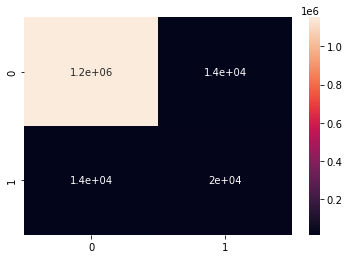

In [31]:
sns.heatmap(cm,annot=True)

In [ ]:
df = pd.read_csv("test_dataset_test.csv", sep = ',')

In [ ]:
df['oper_type']=df['oper_type + oper_attr'].apply(lambda x: str(x)[:str(x).find('_')])

In [ ]:
df['oper_attr']=df['oper_type + oper_attr'].apply(lambda x: str(x)[str(x).find('_')+1:])

In [ ]:
df['index_oper'] = df['index_oper'].astype(str)
df['index_oper'] = df['index_oper'].apply(lambda x: x.replace('.0', ''))

In [ ]:
df = df.loc[df['index_oper'] != ' ']

In [ ]:
df['index_oper'] = df['index_oper'].astype(float)

In [ ]:
df['oper_type'] = df['oper_type'].astype(float)
df['oper_attr'] = df['oper_attr'].astype(float)

In [ ]:
df.is_privatecategory=df.is_privatecategory.map({'Y':1, 'N':0})
df.is_in_yandex=df.is_in_yandex.map({'Y':1, 'N':0})
df.is_return=df.is_return.map({'Y':1, 'N':0})
df.type=df.type.map({'Участок':1, 'ММПО':2, 'Цех':3, 'П':4, 'ТИ':5, 'ГОПС':6, 'МСЦ':7, 'СОПС':8, 'АО':9,
                                 'МРП':10, 'СЦ':11, 'МСО':12, 'ОПП':13, 'АОПП':14, 'ПЕРЕДВИЖНОЕ ОС':15, 'ОП':16, '0':17,
                                 'ППС':18, 'УМСЦ':19, 'УКД':20})

In [ ]:
df = df[['id', 'index_oper', 'type', 'priority', 'is_privatecategory', 'class', 'is_in_yandex', 'is_return',
                     'weight', 'mailtype', 'mailctg', 'mailrank', 'directctg', 'transport_pay', 'postmark', 'weight_mfi',
                     'price_mfi', 'dist_qty_oper_login_1', 'total_qty_oper_login_1', 'total_qty_oper_login_0',
                     'total_qty_over_index_and_type', 'total_qty_over_index', 'is_wrong_sndr_name', 'is_wrong_rcpn_name',
                     'is_wrong_phone_number', 'is_wrong_address', 'oper_type', 'oper_attr']]

In [33]:
df_pred = df

In [35]:
df_pred.fillna(df_pred.mean(), inplace=True)

In [40]:
df_pred = df_pred.drop(['Unnamed: 0'], axis=1)

In [41]:
y_pred = tree.predict(df_pred)

In [42]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [48]:
df_lable_res = pd.DataFrame(y_pred).reset_index()

In [49]:
df_lable_res.head()

,index,0
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [50]:
df_result = df_pred['id'].reset_index()
df_result.head()

,index,id
0,0,7815282
1,1,8443555
2,2,6352559
3,3,4921420
4,4,1420440


In [51]:
df_result = df_result.merge(df_lable_res, on = 'index')
df_result

,index,id,0
0,0,7815282,0
1,1,8443555,0
2,2,6352559,0
3,3,4921420,0
4,4,1420440,0
...,...,...,...
3999894,3999894,9030800,0
3999895,3999895,6275048,0
3999896,3999896,4701757,0
3999897,3999897,611153,0


In [52]:
df_result = df_result.drop(['index'], axis=1)
df_result.columns = (['id', 'lable'])

In [55]:
df_result.describe()

,id,lable
count,3.999899e+06,3.999899e+06
mean,5.001241e+06,2.878248e-02
std,2.887143e+06,1.671947e-01
min,0.000000e+00,0.000000e+00
25%,2.499766e+06,0.000000e+00
50%,5.000932e+06,0.000000e+00
75%,7.502302e+06,0.000000e+00
max,9.999998e+06,1.000000e+00


In [57]:
df_result.to_csv('Result_Post.csv', sep = ',')